In [1]:
!pip install h5py

Lo archivos proporcionados se encuentran en formato h5. h5 es un  formato de datos jerárquico de código abierto, versión 5 (HDF5) que admite datos grandes, complejos y heterogéneos. Utiliza una estructura similar a un «directorio de archivos» que le permite organizar los datos dentro del archivo de muchas formas estructuradas diferentes organizados en grupos y datasets.
 ## Estructura intena de los archivos h5
* Grupo: un elemento similar a una carpeta dentro de un archivo HDF5 que puede contener otros grupos O conjuntos de datos dentro de él.
* Datasets: los datos reales contenidos en el archivo HDF5. Los conjuntos de datos se almacenan a menudo (pero no es necesario) dentro de grupos en el archivo.


Normalizar bandas para que queden entre cero y uno " VALORES NEGATIVOS CON ERRO"

![estructura de archivo HDF5 que contiene grupos, conjuntos de datos y metadatos asociados.](h5.png)


In [1]:
#Bibliotecas utilizadas
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas utilizadas para la regresión logistica

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns



### Explorando los archivos h5

In [3]:
# Abrir el archivo en modo lectura
with h5py.File("test_data.h5", "r") as archivo:
    print("Grupos disponibles:", list(archivo.keys()))
    imagenes_test= archivo["images"][:]
   



Grupos disponibles: ['images']


In [4]:
with h5py.File("train_data.h5", "r") as archivo:
    print("Grupos disponibles:", list(archivo.keys()))
    etiquetas = archivo["labels"][:] # guardo las etiquetas en una variable para analizar las clases
    imagenes= archivo["images"][:]

Grupos disponibles: ['images', 'labels']


In [6]:
print("Shape de las imágenes:", imagenes.shape)

# Para ver las estadísticas de cada banda
n_bandas = imagenes.shape[-1]
for i in range(n_bandas):
    banda = imagenes[:, :, :, i].ravel()  # a vector
    print(f"Banda {i} -> min: {banda.min()}, max: {banda.max()}, mean: {banda.mean()}, std: {banda.std()}")


Shape de las imágenes: (1100000, 16, 16, 6)
Banda 0 -> min: -9999, max: 20000, mean: 1563.4441534588068, std: 1020.3251315891744
Banda 1 -> min: -9999, max: 20000, mean: 1563.4422013494318, std: 1020.3129846111095
Banda 2 -> min: -9999, max: 20000, mean: 1561.1524800177556, std: 1018.9456906902228
Banda 3 -> min: -9999, max: 20000, mean: 1561.1560117649149, std: 1018.9367176153811
Banda 4 -> min: -9999, max: 20000, mean: 1562.1717624289772, std: 1018.8703523621095
Banda 5 -> min: -9999, max: 20000, mean: 1562.1718712571023, std: 1018.8591968526678


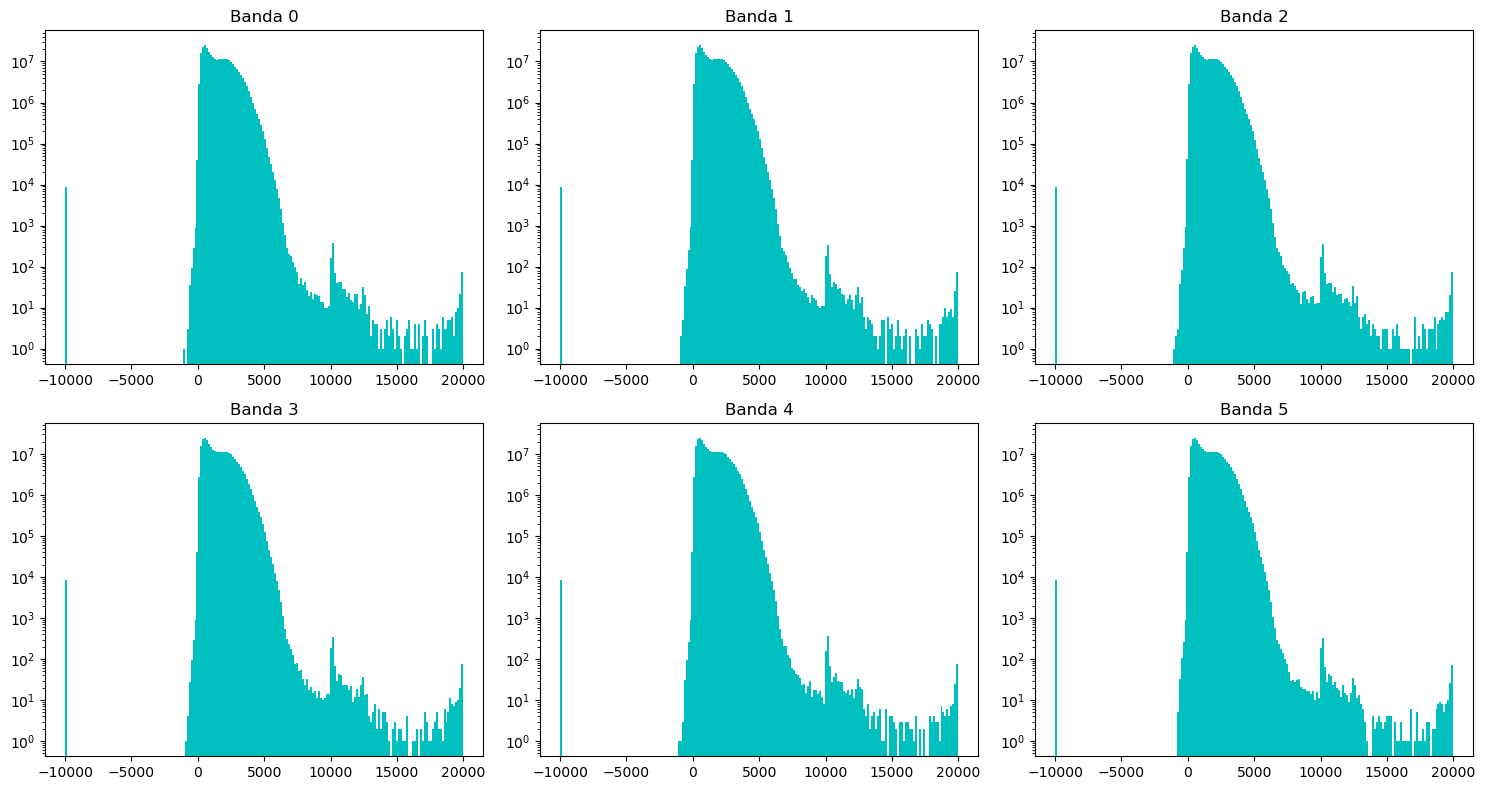

In [9]:
#graficar histograms por banda
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    banda = imagenes[:, :, :, i].ravel()
    ax.hist(banda, bins=200, color="#00BFBF")
    ax.set_yscale("log")   
    ax.set_title(f"Banda {i}")

plt.tight_layout()
plt.show()


In [9]:
import numpy as np

n_bandas = imagenes.shape[-1]

for i in range(n_bandas):
    banda = imagenes[:, :, :, i].ravel()
    n_nodata = np.sum(banda == -9999)   
    n_total = banda.size               
    porcentaje = (n_nodata / n_total) * 100

    print(f"Banda {i}: NoData = {n_nodata:,} ")


Banda 0: NoData = 8,572 
Banda 1: NoData = 8,560 
Banda 2: NoData = 8,572 
Banda 3: NoData = 8,560 
Banda 4: NoData = 8,572 
Banda 5: NoData = 8,560 


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def correccion_log_minmax(imagenes, epsilon=1e-6):
   
    #  Recortar negativos a 0
    imagenes = np.where(imagenes < 0, 0, imagenes)
    
    # Aplicar log-transform (log1p) para valores pequeños
    imagenes = np.log1p(imagenes + epsilon)  # evita log(0)
    
    # Escalado Min-Max por banda
    n_bandas = imagenes.shape[-1]
    for i in range(n_bandas):
        banda = imagenes[..., i].reshape(-1, 1)
        scaler = MinMaxScaler()
        banda_scaled = scaler.fit_transform(banda).reshape(imagenes[..., i].shape)
        imagenes[..., i] = banda_scaled
    
    return imagenes


# Aplicar corrección log + Min-Max a train y test

imagenes_train_corr = correccion_log_minmax(imagenes)
imagenes_test_corr = correccion_log_minmax(imagenes_test)

# Verificar estadísticas por banda
for i in range(imagenes_train_corr.shape[-1]):
    banda = imagenes_train_corr[..., i]
    print(f"Banda {i}: min={np.min(banda):.4f}, max={np.max(banda):.4f}, mean={np.mean(banda):.4f}, std={np.std(banda):.4f}")

print("Corrección log + Min-Max Scaling aplicada a train y test.")



Banda 0: min=0.0000, max=1.0000, mean=0.7171, std=0.0774
Banda 1: min=0.0000, max=1.0000, mean=0.7171, std=0.0774
Banda 2: min=0.0000, max=1.0000, mean=0.7170, std=0.0774
Banda 3: min=0.0000, max=1.0000, mean=0.7170, std=0.0774
Banda 4: min=0.0000, max=1.0000, mean=0.7171, std=0.0773
Banda 5: min=0.0000, max=1.0000, mean=0.7171, std=0.0773
Corrección log + Min-Max Scaling aplicada a train y test.


In [9]:
#borro variables que no voy a usar para no saturar la memoria
del imagenes
del imagenes_test

##### a. Explore the dataset to assess class distribution (0 = no settlement, 1 = settlement) and identify potential imbalance.

In [11]:
clases, conteos = np.unique(etiquetas, return_counts=True)
print(clases)
print(conteos)


[0 1]
[1000000  100000]


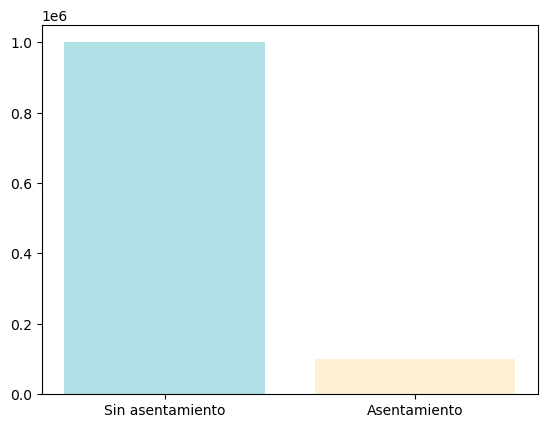

In [13]:
#graficar
etiquetas_personalizadas = ["Sin asentamiento", "Asentamiento"]
colores = ['#B0E0E6', '#FFEFD5']

plt.bar(clases, conteos, color=colores)  
plt.xticks(clases, etiquetas_personalizadas)  

plt.show()

## DATOS DE ENTRENAMIENTO

##### b. Apply a balancing strategy (e.g., undersampling, oversampling, SMOTE) and justify your choice.
##### Balanceo de clases

Aplico undersampling aleatorio, es una técnica para balancear las clases eliminando muestras solo de la clase mayoritaria, la cual consiste en:

Identificar la clase mayoritaria

Elimina aleatoriamente ejemplos de esa clase hasta que quede la misma cantidad que la clase minoritaria

Deja intacta la clase minoritaria.

In [15]:
#aplano los datos vara que sea de 2d y lo pueda manipular como un dataframe 
imagenes_reshaped = imagenes_train_corr.reshape(imagenes_train_corr.shape[0], -1)
print(f"Tamaño de imagenes aplanadas: {imagenes_reshaped.shape}")
#convierto los datos de la imagenes y las etiquetas a un dataframe

img_train = pd.DataFrame(imagenes_reshaped)
etiquetas_train = pd.DataFrame(etiquetas, columns=["etiqueta"])
#uno los datos para tener solo un set de datos 

train_join = pd.concat([img_train, etiquetas_train], axis=1)

# Filtro por clase 
clase_0 = train_join[train_join['etiqueta'] == 0]
clase_1 = train_join[train_join['etiqueta'] == 1]

print(imagenes_reshaped[:1,:])

Tamaño de imagenes aplanadas: (1100000, 1536)
[[0.65826448 0.64524825 0.63244047 ... 0.68809176 0.67893236 0.68853414]]


In [20]:


# Número de elementos que NO son NaN en la columna 'etiqueta'
num_etiquetados = train_join['etiqueta'].notna().sum()

print(f"Número de elementos con etiqueta: {num_etiquetados}")


Número de elementos con etiqueta: 1100000


In [23]:
n_clase_0= len(clase_0)
print(n_clase_0)
n_clase_1= len(clase_1)
print(n_clase_1)
#obten la clase con el minimo 
clases=int(min(n_clase_0, n_clase_1))

1000000
100000


In [25]:
#submuestrar aleatoriamente cada clase 

clase_0_sub = clase_0.sample(n=clases, random_state=112).copy()
clase_1_sub = clase_1.sample(n=clases, random_state=112).copy()

# Añadir columna de etiqueta explícita
clase_0_sub["etiqueta"] = 0
clase_1_sub["etiqueta"] = 1


resampled = pd.concat([clase_0_sub, clase_1_sub])

print(resampled.head())
conteos = resampled["etiqueta"].value_counts()
print(conteos)


                0         1         2         3         4         5         6  \
768105   0.639137  0.638052  0.638052  0.652598  0.648417  0.648253  0.653850   
718586   0.575597  0.589164  0.600860  0.596013  0.605987  0.607476  0.626090   
329795   0.709307  0.724461  0.726678  0.726148  0.725461  0.719874  0.697302   
1062221  0.632633  0.655548  0.675852  0.683210  0.675350  0.654006  0.641977   
115979   0.678446  0.677588  0.676475  0.679175  0.685168  0.676351  0.658264   

                7         8         9  ...      1527      1528      1529  \
768105   0.638777  0.618655  0.607967  ...  0.721956  0.742600  0.724924   
718586   0.639317  0.657966  0.653070  ...  0.714643  0.720920  0.716751   
329795   0.699206  0.711264  0.707494  ...  0.806635  0.808704  0.808738   
1062221  0.636216  0.646260  0.673830  ...  0.773947  0.769047  0.746962   
115979   0.653539  0.662636  0.656461  ...  0.794373  0.792735  0.791429   

             1530      1531      1532      1533      153

In [27]:
#separar las categorias 
img_train_resampled = resampled.drop(columns='etiqueta')
etiquetas_train_resampled = resampled['etiqueta'] 

img_union= pd.concat([img_train_resampled, etiquetas_train_resampled])

clase2, conteo2 = np.unique(etiquetas_train_resampled, return_counts=True)

In [29]:
#revisión 
print(clases)
print(conteos)

100000
etiqueta
0    100000
1    100000
Name: count, dtype: int64


In [31]:
print(img_train_resampled.head())



# Número de elementos que NO son NaN en la columna 'etiqueta'
num_etiquetados = resampled['etiqueta'].notna().sum()

print(f"Número de elementos con etiqueta: {num_etiquetados}")

             0         1         2         3         4         5         6     \
768105   0.639137  0.638052  0.638052  0.652598  0.648417  0.648253  0.653850   
718586   0.575597  0.589164  0.600860  0.596013  0.605987  0.607476  0.626090   
329795   0.709307  0.724461  0.726678  0.726148  0.725461  0.719874  0.697302   
1062221  0.632633  0.655548  0.675852  0.683210  0.675350  0.654006  0.641977   
115979   0.678446  0.677588  0.676475  0.679175  0.685168  0.676351  0.658264   

             7         8         9     ...      1526      1527      1528  \
768105   0.638777  0.618655  0.607967  ...  0.721399  0.721956  0.742600   
718586   0.639317  0.657966  0.653070  ...  0.727206  0.714643  0.720920   
329795   0.699206  0.711264  0.707494  ...  0.803680  0.806635  0.808704   
1062221  0.636216  0.646260  0.673830  ...  0.769493  0.773947  0.769047   
115979   0.653539  0.662636  0.656461  ...  0.793128  0.794373  0.792735   

             1529      1530      1531      1532      153

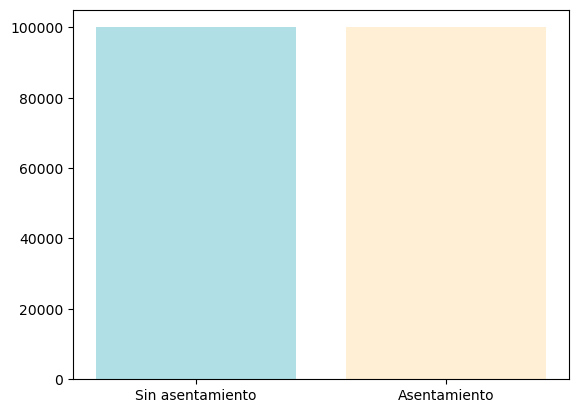

In [33]:
#graficar
etiquetas_personalizadas = ["Sin asentamiento", "Asentamiento"]
colores = ['#B0E0E6', '#FFEFD5']

plt.bar(clase2, conteo2, color=colores)  
plt.xticks(clase2, etiquetas_personalizadas)  

plt.show()

#### c. Extract relevant features from the data, either statistical or spectral.

In [35]:

#  Funciones para extraer caracteristicas
def kurtosis(x):
    x = np.atleast_1d(x)
    n = len(x)
    media = np.mean(x)
    std = np.std(x)
    if std == 0:
        return 0
    m4 = np.sum((x - media)**4) / n
    return m4 / (std**4) - 3

def energia(x):
    return np.sum(x ** 2)

def entropia(x, bins=256):
    hist, _ = np.histogram(x, bins=bins, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def dispersion(x):
    media = np.mean(x)
    std = np.std(x)
    return std / media if media != 0 else 0

# Variables
n_bandas = 6
n_pixeles_por_banda = 256
columnas_pixeles = resampled.columns[:-1]  # todas menos 'etiqueta'

features_list = []

# extracción de caracteristicas
for pixeles, etiqueta in zip(resampled[columnas_pixeles].values, resampled['etiqueta']):
    features = {}

    for b in range(n_bandas):
        start = b * n_pixeles_por_banda
        end = (b + 1) * n_pixeles_por_banda
        banda_data = pixeles[start:end]

        # Estadísticas en el dominio espacial
        features[f'banda{b+1}_mean'] = np.mean(banda_data)
        features[f'banda{b+1}_std'] = np.std(banda_data)
        features[f'banda{b+1}_kurtosis'] = kurtosis(banda_data)
        features[f'banda{b+1}_energia'] = energia(banda_data)
        features[f'banda{b+1}_entropia'] = entropia(banda_data)
        features[f'banda{b+1}_dispersion'] = dispersion(banda_data)

        # FFT (espectral)
        fft_vals = np.abs(np.fft.fft(banda_data))
        features[f'banda{b+1}_fft_mean'] = np.mean(fft_vals)
        features[f'banda{b+1}_fft_std'] = np.std(fft_vals)
        features[f'banda{b+1}_fft_max'] = np.max(fft_vals)
        features[f'banda{b+1}_fft_min'] = np.min(fft_vals)
        features[f'banda{b+1}_fft_median'] = np.median(fft_vals)
        features[f'banda{b+1}_fft_kurtosis'] = kurtosis(fft_vals)
        features[f'banda{b+1}_fft_energia'] = energia(fft_vals)
        features[f'banda{b+1}_fft_entropia'] = entropia(fft_vals)
        features[f'banda{b+1}_fft_dispersion'] = dispersion(fft_vals)

    # Etiqueta
    features['etiqueta'] = etiqueta
    features_list.append(features)

# DataFrame final ---------------------------
features_df = pd.DataFrame(features_list)

# Revisar conteo de clases
print(features_df['etiqueta'].value_counts())



etiqueta
0    100000
1    100000
Name: count, dtype: int64


### Revisión


In [37]:
print(features_df.shape) # son 15 x 6 caracteristicas  = 90 + etiqueta

print(imagenes_reshaped.shape)
features_df['etiqueta'].unique()        # Valores únicos
features_df['etiqueta'].value_counts()  # Frecuencia de cada etiqueta
features_df.head()




(200000, 91)
(1100000, 1536)


,banda1_mean,banda1_std,banda1_kurtosis,banda1_energia,banda1_entropia,banda1_dispersion,banda1_fft_mean,banda1_fft_std,banda1_fft_max,banda1_fft_min,...,banda6_fft_mean,banda6_fft_std,banda6_fft_max,banda6_fft_min,banda6_fft_median,banda6_fft_kurtosis,banda6_fft_energia,banda6_fft_entropia,banda6_fft_dispersion,etiqueta
0,0.619590,0.030724,0.287422,98.518014,-7062.467834,0.049587,0.887578,9.885860,158.615095,0.011264,...,1.082326,11.812518,189.525100,0.015402,0.190016,249.992819,36020.995257,0.248930,10.914014,0
1,0.574801,0.026222,0.438523,84.757506,-7802.625834,0.045620,0.799568,9.171597,147.149102,0.002077,...,0.995193,10.997411,176.418777,0.017078,0.140435,249.900826,31214.965607,0.205875,11.050534,0
2,0.708452,0.009825,0.177404,128.512149,-24664.926734,0.013868,0.812016,11.307200,181.363679,0.001222,...,0.908263,12.849433,206.089648,0.002324,0.072993,250.966296,42478.812131,-0.342862,14.147262,0
3,0.665004,0.017208,-0.795478,113.286728,-15311.172020,0.025876,0.830015,10.611211,170.240997,0.005353,...,0.928341,12.187961,195.521135,0.002292,0.099246,250.829963,38248.500875,-0.149539,13.128756,0
4,0.664794,0.007773,0.741377,113.154912,-28506.106193,0.011692,0.745095,10.611303,170.187244,0.001829,...,0.935976,12.552287,201.361214,0.006470,0.086585,250.909105,40559.604725,-0.309786,13.410904,0


## Datos de prueba 

In [41]:
#aplano los datos vara que sea de 2d y lo pueda manipular como un dataframe 
imagenes_reshaped_test = imagenes_test_corr.reshape(imagenes_test_corr.shape[0], -1) # Tamaño(1100000, 1536)
#convierto los datos de la imagenes y las etiquetas a un dataframe
img_test= pd.DataFrame(imagenes_reshaped_test)

In [43]:


#Variables
n_bandas = 6
n_pixeles_por_banda = 256
columnas_pixeles = img_test.columns.tolist()


features_list_test = []

# Extraer caracteristicas
for _, row in img_test.iterrows():
    
    pixeles = row[columnas_pixeles].values
    features = {}

    for b in range(n_bandas):
        start = b * n_pixeles_por_banda
        end = (b + 1) * n_pixeles_por_banda
        banda_data = pixeles[start:end]

        # Estadísticas en el dominio espacial
        features[f'banda{b+1}_mean'] = np.mean(banda_data)
        features[f'banda{b+1}_std'] = np.std(banda_data)
        features[f'banda{b+1}_kurtosis'] = kurtosis(banda_data)
        features[f'banda{b+1}_energia'] = energia(banda_data)
        features[f'banda{b+1}_entropia'] = entropia(banda_data)
        features[f'banda{b+1}_dispersion'] = dispersion(banda_data)

        # FFT (espectrales)
        fft_vals = np.abs(np.fft.fft(banda_data))
        features[f'banda{b+1}_fft_mean'] = np.mean(fft_vals)
        features[f'banda{b+1}_fft_std'] = np.std(fft_vals)
        features[f'banda{b+1}_fft_max'] = np.max(fft_vals)
        features[f'banda{b+1}_fft_min'] = np.min(fft_vals)
        features[f'banda{b+1}_fft_median'] = np.median(fft_vals)
        features[f'banda{b+1}_fft_kurtosis'] = kurtosis(fft_vals)
        features[f'banda{b+1}_fft_energia'] = energia(fft_vals)
        features[f'banda{b+1}_fft_entropia'] = entropia(fft_vals)
        features[f'banda{b+1}_fft_dispersion'] = dispersion(fft_vals)

    features_list_test.append(features)

   
# ==== DataFrame final ====
features_df_test = pd.DataFrame(features_list_test)


#### d. Train a traditional machine learning model (e.g., Random Forest, SVM, Logistic Regression, etc.)


# Regresion logística balanceada

In [47]:

# Separar variables (X) y etiquetas (y) del set features_df
X_train = features_df.drop(columns='etiqueta')
y_train = features_df['etiqueta']



# Dividir el set train en entrenamiento y validación ( 80%-20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


print("Distribución en y_tr:")
print(y_tr.value_counts())

print("\nDistribución en y_val:")
print(y_val.value_counts())


Distribución en y_tr:
etiqueta
0    80000
1    80000
Name: count, dtype: int64

Distribución en y_val:
etiqueta
1    20000
0    20000
Name: count, dtype: int64


In [77]:

# Simulación de entrenamiento por épocas

n_epochs = 250

logreg = LogisticRegression(
    max_iter=1,        
    solver="saga",     
    warm_start=True
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", logreg)
])

history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "auc": [], "val_auc": []
}

for epoch in range(n_epochs):
    model.fit(X_train, y_train)

    # Predicciones en train y validación
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_val_prob = model.predict_proba(X_valid)[:, 1]
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_val_pred = (y_val_prob >= 0.5).astype(int)

    # Guardarmétricas
    history["loss"].append(log_loss(y_train, y_train_prob))
    history["val_loss"].append(log_loss(y_valid, y_val_prob))
    history["accuracy"].append(accuracy_score(y_train, y_train_pred))
    history["val_accuracy"].append(accuracy_score(y_valid, y_val_pred))
    try:
        history["auc"].append(roc_auc_score(y_train, y_train_prob))
        history["val_auc"].append(roc_auc_score(y_valid, y_val_prob))
    except:
        history["auc"].append(np.nan)
        history["val_auc"].append(np.nan)


# Reporte de clasificación final

print("Reporte de clasificación final:")
print(classification_report(y_valid, y_val_pred))




C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was re

Reporte de clasificación final:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     20000
           1       0.78      0.77      0.77     20000

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



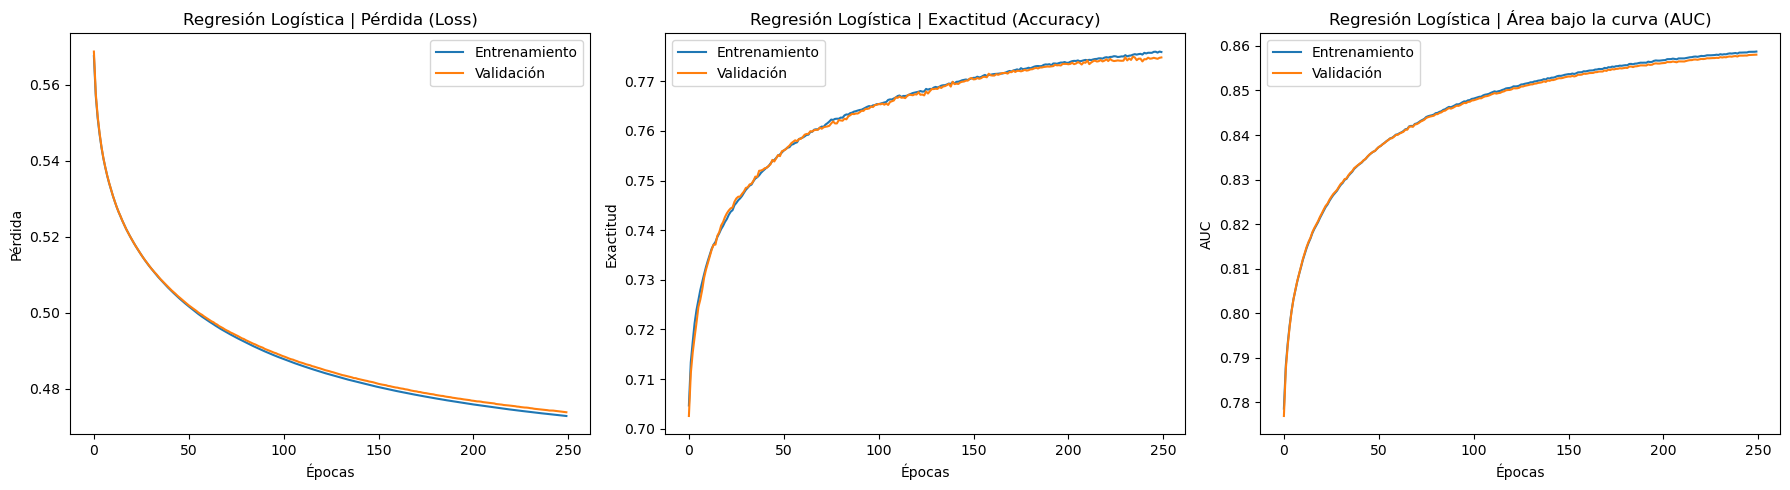

In [79]:

#Gráficas de convergenci

has_acc = "accuracy" in history and "val_accuracy" in history
has_auc = "auc" in history and "val_auc" in history

ncols = 1 + int(has_acc) + int(has_auc)
fig, ax = plt.subplots(1, ncols, figsize=(6*ncols, 5))
ax = ax if ncols > 1 else [ax]

i = 0
# Pérdida (Loss)
ax[i].plot(history["loss"], label="Entrenamiento")
ax[i].plot(history["val_loss"], label="Validación")
ax[i].set_title("Regresión Logística | Pérdida (Loss)")
ax[i].set_xlabel("Épocas")
ax[i].set_ylabel("Pérdida")
ax[i].legend()
i += 1

# Exactitud (Accuracy)
if has_acc:
    ax[i].plot(history["accuracy"], label="Entrenamiento")
    ax[i].plot(history["val_accuracy"], label="Validación")
    ax[i].set_title("Regresión Logística | Exactitud (Accuracy)")
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel("Exactitud")
    ax[i].legend()
    i += 1

# AUC
if has_auc:
    ax[i].plot(history["auc"], label="Entrenamiento")
    ax[i].plot(history["val_auc"], label="Validación")
    ax[i].set_title("Regresión Logística | Área bajo la curva (AUC)")
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel("AUC")
    ax[i].legend()
    i += 1

plt.tight_layout()
plt.show()



In [55]:
model.fit(X_train, y_train)
#  Predecir etiquetas del set de test (features_df_test, sin etiqueta)
y_test_pred = model.predict(features_df_test)

#mostrar predicciones
print("Predicciones en test:", y_test_pred)

Predicciones en test: [1 0 0 ... 1 0 0]


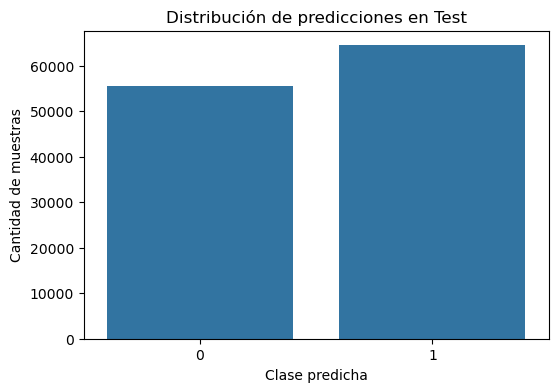

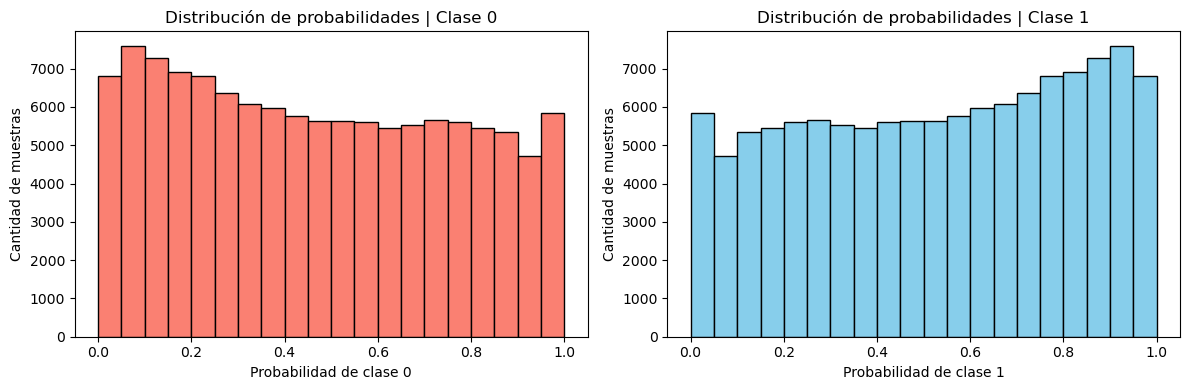

In [83]:

#Gráfica de distribución de predicciones

plt.figure(figsize=(6,4))
sns.countplot(x=y_test_pred)
plt.xlabel("Clase predicha")
plt.ylabel("Cantidad de muestras")
plt.title("Distribución de predicciones en Test")
plt.show()

# 
# Probabilidades de clase

if hasattr(model, "predict_proba"):
    # Probabilidades de clase 0 y clase 1
    y_test_prob_0 = model.predict_proba(features_df_test)[:, 0]
    y_test_prob_1 = model.predict_proba(features_df_test)[:, 1]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Clase 0
    axes[0].hist(y_test_prob_0, bins=20, color='salmon', edgecolor='k')
    axes[0].set_xlabel("Probabilidad de clase 0")
    axes[0].set_ylabel("Cantidad de muestras")
    axes[0].set_title("Distribución de probabilidades | Clase 0")
    
    # Clase 1
    axes[1].hist(y_test_prob_1, bins=20, color='skyblue', edgecolor='k')
    axes[1].set_xlabel("Probabilidad de clase 1")
    axes[1].set_ylabel("Cantidad de muestras")
    axes[1].set_title("Distribución de probabilidades | Clase 1")
    
    plt.tight_layout()
    plt.show()



Grupos disponibles: ['images', 'labels']
Shape del dataset: (1100000, 16, 16, 6)


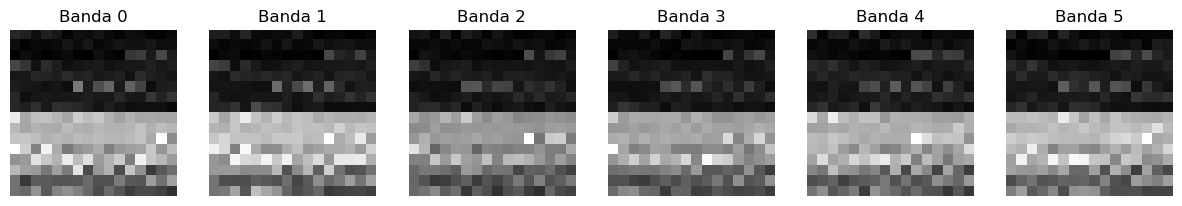

In [59]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("train_data.h5", "r") as archivo:
    print("Grupos disponibles:", list(archivo.keys()))  # Lista las claves principales
    
    # "images" es directamente un Dataset
    dataset = archivo["images"][:]  # Lo cargamos como array de numpy

print("Shape del dataset:", dataset.shape)

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(dataset[0, :, :, i], cmap="gray")
    axes[i].set_title(f"Banda {i}")
    axes[i].axis("off")
plt.show()



# Random forest

In [61]:
# === Asegurar splits: X_train, X_valid, y_train, y_valid ===
from sklearn.model_selection import train_test_split
import gc

from sklearn.model_selection import train_test_split
import gc

def ensure_train_valid(globs):
    """
    Garantiza que existan X_train, y_train, X_valid, y_valid en el entorno global.
    - Caso A: Ya tienes X, y  -> split 80/20.
    - Caso B: Tienes X_train, y_train pero no valid -> saca 20% de valid del train.
    - Caso C: Tienes X_train, X_test, y_train, y_test -> usa test como valid (solo si es para evaluación intermedia).
    """
    # Ya definidos?
    if all(k in globs for k in ['X_train', 'y_train', 'X_valid', 'y_valid']):
        print("✔ X_train / y_train / X_valid / y_valid ya existen.")
        return globs['X_train'], globs['y_train'], globs['X_valid'], globs['y_valid']

    # Caso A: X, y globales
    if 'X' in globs and 'y' in globs:
        print("→ Creando train/valid desde X, y (80/20, estratificado).")
        X_train, X_valid, y_train, y_valid = train_test_split(
            globs['X'], globs['y'],
            test_size=0.2, random_state=42,
            stratify=globs['y'] if hasattr(globs['y'], '__len__') else None
        )
        globs['X_train'], globs['X_valid'], globs['y_train'], globs['y_valid'] = X_train, X_valid, y_train, y_valid
        gc.collect()
        return X_train, y_train, X_valid, y_valid

    # Caso B: Solo tienes X_train, y_train
    if 'X_train' in globs and 'y_train' in globs:
        print("→ Particionando X_train/y_train en train(80%) y valid(20%).")
        Xtr, Xva, ytr, yva = train_test_split(
            globs['X_train'], globs['y_train'],
            test_size=0.2, random_state=42,
            stratify=globs['y_train'] if hasattr(globs['y_train'], '__len__') else None
        )
        globs['X_train'], globs['X_valid'], globs['y_train'], globs['y_valid'] = Xtr, Xva, ytr, yva
        gc.collect()
        return Xtr, ytr, Xva, yva

    # Caso C: Usa test como valid
    if all(k in globs for k in ['X_train', 'y_train', 'X_test', 'y_test']):
        print("⚠ Usando X_test/y_test como valid (solo para validación intermedia).")
        globs['X_valid'], globs['y_valid'] = globs['X_test'], globs['y_test']
        return globs['X_train'], globs['y_train'], globs['X_valid'], globs['y_valid']

    raise RuntimeError(
        "No encontré variables suficientes. Define al menos (X,y) o (X_train,y_train) "
        "o (X_train,y_train,X_test,y_test)."
    )

# Ejecuta la función
X_train, y_train, X_valid, y_valid = ensure_train_valid(globals())
print("Listo: X_train.shape =", getattr(X_train, "shape", "desconocido"))
print("Listo: X_valid.shape =", getattr(X_valid, "shape", "desconocido"))



→ Particionando X_train/y_train en train(80%) y valid(20%).
Listo: X_train.shape = (160000, 90)
Listo: X_valid.shape = (40000, 90)


In [63]:

# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

# Entrenamos el modelo
rf_model = RandomForestClassifier(
    n_estimators=100,      # número de árboles
    max_depth=None,        # sin límite de profundidad
    random_state=42,
    n_jobs=-1,             # usa todos los núcleos disponibles
    class_weight="balanced"  # balanceasr si existe desbalanceo
)

print("Entrenando modelo Random Forest...")
rf_model.fit(X_train, y_train)

# Predicciones en validación
y_pred = rf_model.predict(X_valid)

# Evaluamos el modelo
acc = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)

print("\nResultados Random Forest:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_valid, y_pred))


Entrenando modelo Random Forest...

Resultados Random Forest:
Accuracy: 0.8046
F1 Score: 0.8049
Recall: 0.8059

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     20000
           1       0.80      0.81      0.80     20000

    accuracy                           0.80     40000
   macro avg       0.80      0.80      0.80     40000
weighted avg       0.80      0.80      0.80     40000



## Sin usar balanceo 
### Calcular las caracteristicas

In [19]:
# Funciones para la extraccion de caracteristicas 
def kurtosis(x):
    x = np.atleast_1d(x)
    n = len(x)
    media = np.mean(x)
    std = np.std(x)
    if std == 0:
        return 0
    m4 = np.sum((x - media)**4) / n
    return m4 / (std**4) - 3

def energia(x):
    return np.sum(x ** 2)

def entropia(x, bins=256):
    hist, _ = np.histogram(x, bins=bins, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def dispersion(x):
    media = np.mean(x)
    std = np.std(x)
    return std / media if media != 0 else 0

In [21]:

# Variables
n_bandas = 6
n_pixeles_por_banda = 256
columnas_pixeles = train_join.columns[:-1]  # todas menos etiqueta

features_list = []

#Extracción de características
for _, row in train_join.iterrows():
    etiqueta = row['etiqueta']
    pixeles = row[columnas_pixeles].values
    features = {}

    for b in range(n_bandas):
        start = b * n_pixeles_por_banda
        end = (b + 1) * n_pixeles_por_banda
        banda_data = pixeles[start:end]

        # Estadísticas en el dominio espacial
        features[f'banda{b+1}_mean'] = np.mean(banda_data)
        features[f'banda{b+1}_std'] = np.std(banda_data)
        features[f'banda{b+1}_kurtosis'] = kurtosis(banda_data)
        features[f'banda{b+1}_energia'] = energia(banda_data)
        features[f'banda{b+1}_entropia'] = entropia(banda_data)
        features[f'banda{b+1}_dispersion'] = dispersion(banda_data)

        # FFT
        fft_vals = np.abs(np.fft.fft(banda_data))
        features[f'banda{b+1}_fft_mean'] = np.mean(fft_vals)
        features[f'banda{b+1}_fft_std'] = np.std(fft_vals)
        features[f'banda{b+1}_fft_max'] = np.max(fft_vals)
        features[f'banda{b+1}_fft_min'] = np.min(fft_vals)
        features[f'banda{b+1}_fft_median'] = np.median(fft_vals)
        features[f'banda{b+1}_fft_kurtosis'] = kurtosis(fft_vals)
        features[f'banda{b+1}_fft_energia'] = energia(fft_vals)
        features[f'banda{b+1}_fft_entropia'] = entropia(fft_vals)
        features[f'banda{b+1}_fft_dispersion'] = dispersion(fft_vals)

    # Etiqueta
    features['etiqueta'] = etiqueta
    features_list.append(features)

# ==== DataFrame final ====
features_org = pd.DataFrame(features_list)


## Regresión logística


In [23]:


# 1. Separar variables (X) y etiquetas (y) del set features_df
X_train = features_org.drop(columns='etiqueta')
y_train = features_org['etiqueta']



# 2. Dividir el set train en entrenamiento y validación ( 80%-20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


print("Distribución en y_tr:")
print(y_tr.value_counts())

print("\nDistribución en y_val:")
print(y_val.value_counts())


Distribución en y_tr:
etiqueta
0.0    800000
1.0     80000
Name: count, dtype: int64

Distribución en y_val:
etiqueta
0.0    200000
1.0     20000
Name: count, dtype: int64


In [ ]:
logreg = LogisticRegression(
    max_iter=200,               
    solver="saga",            
    random_state=42,
    class_weight="balanced",  # Balancear clases
    warm_start=True           # Permite continuar entrenando si se re-ajusta
)

model = Pipeline([
    ("scaler", StandardScaler()),  # Estandarizar datos
    ("logreg", logreg)             
])


# Entrenar modelo

model.fit(X_train, y_train)


# Predecir probabilidades en validación

y_val_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades clase positiva

## Encontrar el umbral adecuado

=== Métricas con distintos thresholds ===
 threshold  precision  recall       f1
      0.01   0.094745 0.99880 0.173073
      0.06   0.103793 0.99410 0.187961
      0.11   0.115184 0.98600 0.206271
      0.16   0.128724 0.97335 0.227377
      0.21   0.144328 0.95660 0.250814
      0.26   0.161589 0.93570 0.275587
      0.31   0.180380 0.90900 0.301026
      0.36   0.201175 0.88030 0.327505
      0.41   0.224419 0.84615 0.354750
      0.46   0.250588 0.81040 0.382806
      0.51   0.280073 0.76705 0.410324
      0.56   0.313771 0.72340 0.437695
      0.61   0.351744 0.67410 0.462274
      0.66   0.395261 0.62060 0.482938
      0.71   0.443716 0.55835 0.494476
      0.76   0.498003 0.49255 0.495262
      0.81   0.564462 0.41900 0.480973
      0.86   0.643570 0.33530 0.440894
      0.91   0.722273 0.23640 0.356212
      0.96   0.802928 0.11245 0.197272

Mejor threshold según F1-score: 0.73 (F1=0.497)

=== Reporte con threshold óptimo ===
              precision    recall  f1-score   suppor

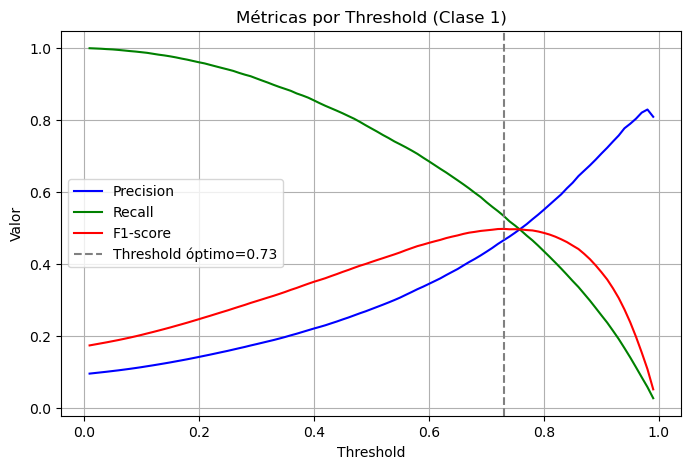

In [48]:


# Definir thresholds

thresholds = np.arange(0.01, 1.0, 0.01)
stats_list = []


# Calcular métricas por threshold

for t in thresholds:
    y_val_pred = (y_val_prob >= t).astype(int)
    report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
    
    # Clase positiva "1.0"
    if "1.0" in report:
        prec = report["1.0"]["precision"]
        rec  = report["1.0"]["recall"]
        f1   = report["1.0"]["f1-score"]
    else:
        prec, rec, f1 = 0, 0, 0

    stats_list.append({
        "threshold": t,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

# Convertir a DataFrame
stats_df = pd.DataFrame(stats_list)


# Imprimir Metricas 

print("=== Métricas con distintos thresholds ===")
print(stats_df[::5].to_string(index=False))  
# Mejor threshold según F1
best_row = stats_df.loc[stats_df['f1'].idxmax()]
best_t = best_row['threshold']
best_f1 = best_row['f1']
print(f"\nMejor threshold según F1-score: {best_t:.2f} (F1={best_f1:.3f})")


# Reporte final con threshold óptimo

y_val_pred_best = (y_val_prob >= best_t).astype(int)
print("\n=== Reporte con threshold óptimo ===")
print(classification_report(y_val, y_val_pred_best, zero_division=0))


# Graficar Precision, Recall y F1 por threshold

plt.figure(figsize=(8,5))
plt.plot(stats_df['threshold'], stats_df['precision'], label="Precision", color='blue')
plt.plot(stats_df['threshold'], stats_df['recall'], label="Recall", color='green')
plt.plot(stats_df['threshold'], stats_df['f1'], label="F1-score", color='red')
plt.axvline(best_t, color='gray', linestyle='--', label=f"Threshold óptimo={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Métricas por Threshold (Clase 1)")
plt.legend()
plt.grid(True)
plt.show()


## Generar Gráficas para hacer comparaciones 

C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was re

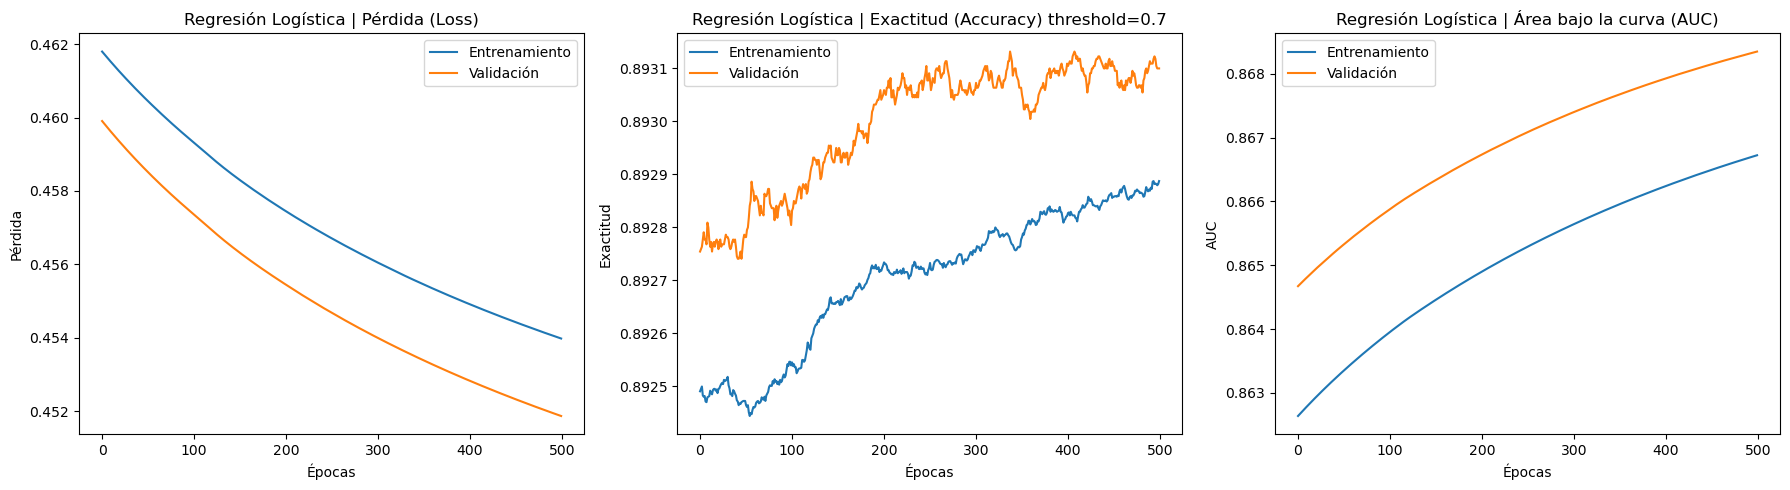

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score


n_epochs = 500 n#iteraciones
threshold = 0.7

# Inicializar historial
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "auc": [], "val_auc": []
}

# Loop por “épocas” 
for epoch in range(n_epochs):
    model.fit(X_tr, y_tr)  

    # Probabilidades
    y_tr_prob  = model.predict_proba(X_tr)[:, 1]
    y_val_prob = model.predict_proba(X_val)[:, 1]

    # Predicciones con threshold=0.7
    y_tr_pred  = (y_tr_prob >= threshold).astype(int)
    y_val_pred = (y_val_prob >= threshold).astype(int)

    # Guardar métricas
    history["loss"].append(log_loss(y_tr, y_tr_prob))
    history["val_loss"].append(log_loss(y_val, y_val_prob))
    history["accuracy"].append(accuracy_score(y_tr, y_tr_pred))
    history["val_accuracy"].append(accuracy_score(y_val, y_val_pred))

    try:
        history["auc"].append(roc_auc_score(y_tr, y_tr_prob))
        history["val_auc"].append(roc_auc_score(y_val, y_val_prob))
    except:
        history["auc"].append(np.nan)
        history["val_auc"].append(np.nan)


# Graficas de convergencia

has_acc = "accuracy" in history and "val_accuracy" in history
has_auc = "auc" in history and "val_auc" in history

ncols = 1 + int(has_acc) + int(has_auc)
fig, ax = plt.subplots(1, ncols, figsize=(6*ncols, 5))
ax = ax if ncols > 1 else [ax]

i = 0
# Loss
ax[i].plot(history["loss"], label="Entrenamiento")
ax[i].plot(history["val_loss"], label="Validación")
ax[i].set_title("Regresión Logística | Pérdida (Loss)")
ax[i].set_xlabel("Épocas")
ax[i].set_ylabel("Pérdida")
ax[i].legend()
i += 1

# Accuracy
if has_acc:
    ax[i].plot(history["accuracy"], label="Entrenamiento")
    ax[i].plot(history["val_accuracy"], label="Validación")
    ax[i].set_title(f"Regresión Logística | Exactitud (Accuracy) threshold={threshold}")
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel("Exactitud")
    ax[i].legend()
    i += 1

# AUC
if has_auc:
    ax[i].plot(history["auc"], label="Entrenamiento")
    ax[i].plot(history["val_auc"], label="Validación")
    ax[i].set_title("Regresión Logística | Área bajo la curva (AUC)")
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel("AUC")
    ax[i].legend()
    i += 1

plt.tight_layout()
plt.show()


C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\katy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was re


Mejor threshold según F1-score: 0.70 (F1=0.456)

=== Reporte con threshold óptimo ===
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    200000
         1.0       0.41      0.51      0.46     20000

    accuracy                           0.89    220000
   macro avg       0.68      0.72      0.70    220000
weighted avg       0.90      0.89      0.89    220000



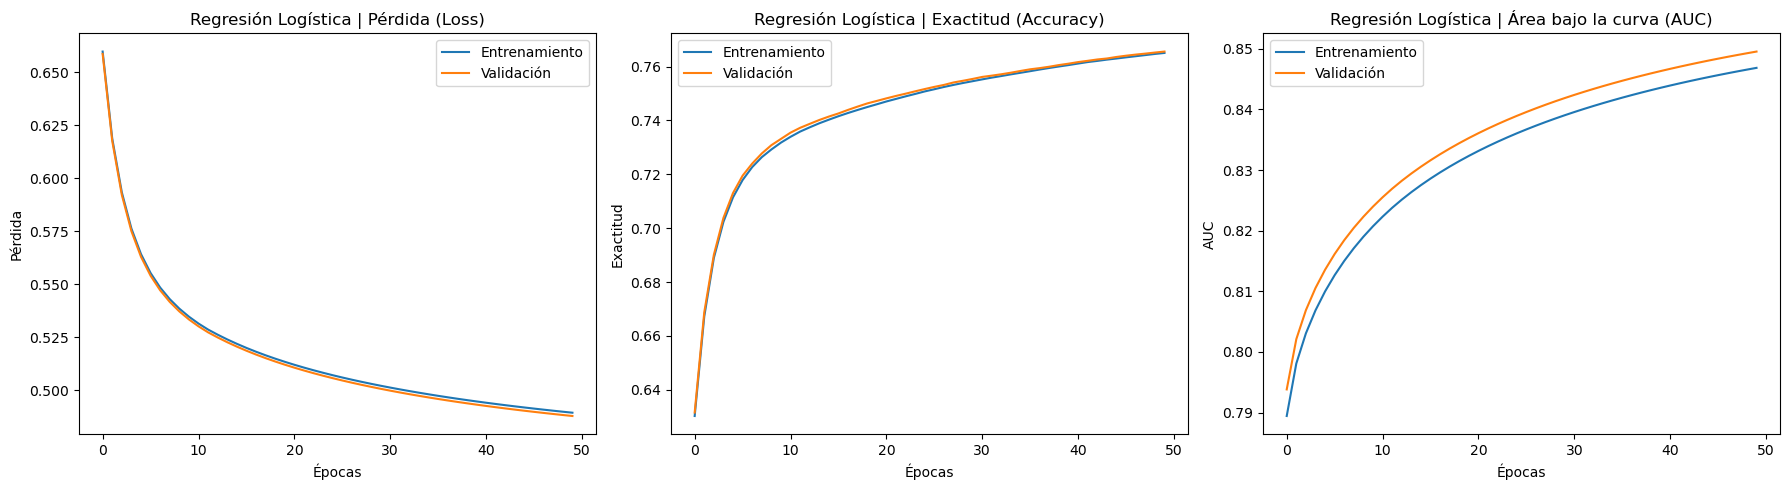

In [35]:



n_epochs = 50  # iteraciones
threshold_default = 0.5


logreg = LogisticRegression(
    max_iter=1,         
    solver="saga",
    random_state=42,
    class_weight="balanced",
    warm_start=True     
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", logreg)
])


# Historial de métricas

history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "auc": [], "val_auc": []
}


for epoch in range(n_epochs):
    model.fit(X_tr, y_tr)

    # Probabilidades
    y_tr_prob  = model.predict_proba(X_tr)[:, 1]
    y_val_prob = model.predict_proba(X_val)[:, 1]

    # Predicciones con threshold 0.5
    y_tr_pred  = (y_tr_prob >= threshold_default).astype(int)
    y_val_pred = (y_val_prob >= threshold_default).astype(int)

    # Guardar métricas
    history["loss"].append(log_loss(y_tr, y_tr_prob))
    history["val_loss"].append(log_loss(y_val, y_val_prob))
    history["accuracy"].append(accuracy_score(y_tr, y_tr_pred))
    history["val_accuracy"].append(accuracy_score(y_val, y_val_pred))
    try:
        history["auc"].append(roc_auc_score(y_tr, y_tr_prob))
        history["val_auc"].append(roc_auc_score(y_val, y_val_prob))
    except:
        history["auc"].append(np.nan)
        history["val_auc"].append(np.nan)


# Determinar threshold óptimo por F1

thresholds = np.arange(0.01, 1.0, 0.01)
best_f1, best_t = 0, threshold_default

for t in thresholds:
    y_val_pred = (y_val_prob >= t).astype(int)
    report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)

    if "1.0" in report:
        f1 = report["1.0"]["f1-score"]
    else:
        f1 = 0

    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"\nMejor threshold según F1-score: {best_t:.2f} (F1={best_f1:.3f})")


# Reporte final con threshold óptimo

y_val_pred_best = (y_val_prob >= best_t).astype(int)
print("\n=== Reporte con threshold óptimo ===")
print(classification_report(y_val, y_val_pred_best, zero_division=0))


# Gráficas de convergencia

has_acc = "accuracy" in history and "val_accuracy" in history
has_auc = "auc" in history and "val_auc" in history

ncols = 1 + int(has_acc) + int(has_auc)
fig, ax = plt.subplots(1, ncols, figsize=(6*ncols, 5))
ax = ax if ncols > 1 else [ax]

i = 0
# Loss
ax[i].plot(history["loss"], label="Entrenamiento")
ax[i].plot(history["val_loss"], label="Validación")
ax[i].set_title("Regresión Logística | Pérdida (Loss)")
ax[i].set_xlabel("Épocas")
ax[i].set_ylabel("Pérdida")
ax[i].legend()
i += 1

# Accuracy
if has_acc:
    ax[i].plot(history["accuracy"], label="Entrenamiento")
    ax[i].plot(history["val_accuracy"], label="Validación")
    ax[i].set_title("Regresión Logística | Exactitud (Accuracy)")
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel("Exactitud")
    ax[i].legend()
    i += 1

# AUC
if has_auc:
    ax[i].plot(history["auc"], label="Entrenamiento")
    ax[i].plot(history["val_auc"], label="Validación")
    ax[i].set_title("Regresión Logística | Área bajo la curva (AUC)")
    ax[i].set_xlabel("Épocas")
    ax[i].set_ylabel("AUC")
    ax[i].legend()
    i += 1

plt.tight_layout()
plt.show()



##Referencias
https://soloelectronicos.com/2021/12/09/como-crear-un-dataset-en-el-formato-h5/